In [1]:
# importamos las bibliotecas necesarias
import pandas as pd  # para manejar los datos en forma de DataFrame
import numpy as np  # para operaciones numéricas
import matplotlib.pyplot as plt  # para visualización de datos
from sklearn.preprocessing import MinMaxScaler  # para escalar los datos
from keras.models import Sequential  # para construir la red neuronal
from keras.layers import LSTM, Dense  # para las capas LSTM y densas
from prophet import Prophet  # para utilizar el modelo Prophet
from sklearn.decomposition import PCA  # para realizar PCA (análisis de componentes principales)
from sklearn.model_selection import train_test_split, cross_val_score  # para dividir los datos y validación cruzada
from sklearn.preprocessing import LabelEncoder, StandardScaler  # para normalizar los datos
from sklearn.linear_model import LogisticRegression  # para regresión logística
from sklearn.tree import DecisionTreeClassifier  # para árboles de decisión
from sklearn.ensemble import RandomForestClassifier  # para random forest
from sklearn.svm import SVC  # para máquinas de soporte vectorial
from sklearn.metrics import  mean_absolute_error, mean_squared_error, classification_report, roc_auc_score  # para evaluar el rendimiento del modelo
from math import sqrt

2024-12-13 14:08:47.858848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### 1. Selección del dataset:
  * Utiliza un dataset de series temporales de Kaggle, como el de «Air Quality Prediction» o cualquier otro relacionado con predicción de demanda, precios de acciones, etc. Puedes elegir el dataset que más se relacione con tus intereses.
  * Enlace sugerido: [Air Quality Prediction](https://www.kaggle.com/competitions/air-quality-prediction)

In [2]:
# cargamos el dataset
ruta='../data/onlinefoods.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(388, 13)

In [3]:
df.head() # mostramos las primeras lineas del dataset

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback,Unnamed: 12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes


In [4]:
df.isnull().sum() # verificamos la existencia de valores nulos

Age                           0
Gender                        0
Marital Status                0
Occupation                    0
Monthly Income                0
Educational Qualifications    0
Family size                   0
latitude                      0
longitude                     0
Pin code                      0
Output                        0
Feedback                      0
Unnamed: 12                   0
dtype: int64

### 2. Preprocesamiento de datos:
  * Realiza una exploración inicial de la serie temporal, incluyendo la visualización de la tendencia y la estacionalidad si es aplicable.
  * Realiza un escalado de los datos, ya que las redes neuronales recurrentes se benefician de que los datos estén en un rango similar.

In [5]:
# seleccionamos solo las columnas numéricas del dataset para aplicar PCA
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# seleccionamos las columnas numéricas del DataFrame
df_numeric = df[numeric_cols]
# antes de aplicar PCA, es importante normalizar los datos (media 0, varianza 1)
scaler = StandardScaler()  # creamos el objeto para normalizar
df_scaled = scaler.fit_transform(df_numeric)  # ajustamos y transformamos los datos
# seleccionamos el número de componentes que expliquen el 90% de la varianza
pca = PCA(n_components=0.90)  # queremos que se retenga al menos el 90% de la variabilidad
df_pca = pca.fit_transform(df_scaled)  # ajustamos y transformamos los datos con PCA

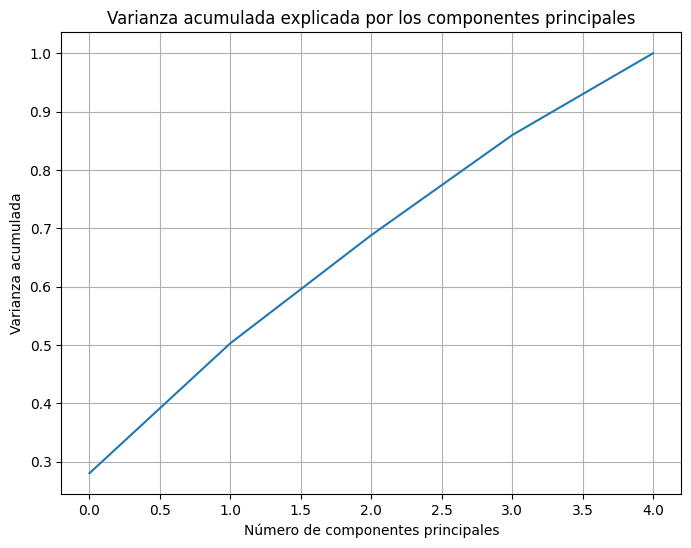

In [6]:
# graficamos la varianza acumulada para ver cuánta varianza se conserva con los primeros componentes
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))  # acumulamos la varianza explicada por cada componente
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada explicada por los componentes principales')
plt.grid(True)
plt.show()

In [7]:
# mostramos la varianza explicada por cada componente individualmente
print("Varianza explicada por cada componente principal:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {ratio*100:.2f}%")

# 7. Usamos las características reducidas
# ahora que hemos reducido la dimensionalidad, el conjunto de datos df_pca tiene menos características
# podemos usar df_pca para simplificar el modelo o realizar más análisis.
print(f"Dimensionalidad antes de PCA: {df_scaled.shape[1]}")
print(f"Dimensionalidad después de PCA: {df_pca.shape[1]}")

Varianza explicada por cada componente principal:
Componente 1: 28.00%
Componente 2: 22.28%
Componente 3: 18.53%
Componente 4: 17.15%
Componente 5: 14.04%
Dimensionalidad antes de PCA: 5
Dimensionalidad después de PCA: 5


### 3. Implementación de RNN con LSTM:
  * Implementa una red LSTM para predecir la serie temporal. Utiliza una arquitectura simple con una capa LSTM y una capa densa para predecir el valor futuro de la serie temporal.
  * Asegúrate de dividir los datos en conjuntos de entrenamiento y prueba, utilizando las primeras partes de la serie para entrenar el modelo y las últimas partes para probar la precisión de las predicciones.

In [8]:
df = df.drop(columns=['Monthly Income']) # eliminamos la columna porque no tiene valores para ningun registro

In [9]:
# Convertir las variables categóricas en valores numéricos con LabelEncoder
label_columns = ['Gender', 'Marital Status', 'Occupation', 'Educational Qualifications', 'Output']
label_encoder = LabelEncoder()

# Convertir las columnas categóricas
for column in label_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Ahora podemos separar las características (X) y la variable objetivo (y)
X = df.drop(columns=['Feedback', 'Unnamed: 12'])  # Eliminar la columna innecesaria
y = df['Output']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # 80% entrenamiento, 20% prueba

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Ahora todas las columnas deben ser numéricas

# Verificar si el error persiste
print(X_scaled[:5])  # Muestra las primeras 5 filas para verificar la normalización


[[-1.55761998 -1.15643824  0.65739091  0.82675596  0.89950569  0.53292917
   0.10222413 -0.01675911 -1.24727362  0.53762119]
 [-0.2116143  -1.15643824  0.65739091  0.82675596 -1.03405779 -0.2082053
   0.11122668 -0.44571189 -0.99216441  0.53762119]
 [-0.88461714  0.86472409  0.65739091  0.82675596  0.89950569 -0.2082053
  -0.38166266  1.15311211 -0.73705521  0.53762119]
 [-0.88461714 -1.15643824  0.65739091  0.82675596 -1.03405779  2.01519811
  -0.55721229 -0.75182819 -0.6732779   0.53762119]
 [-0.88461714  0.86472409  0.65739091  0.82675596  0.89950569  0.53292917
   0.29127758 -0.91366037 -0.96027576  0.53762119]]


In [10]:
# Reshape X para ser compatible con la capa LSTM (tiene que ser 3D)
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))  # 3D array para LSTM

# Entrenamiento del modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
lstm_model.add(Dense(units=1))  # Salida de la predicción
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
lstm_model.fit(X_scaled, y, epochs=10, batch_size=32)

# Realizar predicciones con LSTM
y_pred_lstm = lstm_model.predict(X_scaled)  # o sobre los datos de test si están disponibles


Epoch 1/10


/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6874
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6015
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4902
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3996
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3020 
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2047  
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1483 
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1157
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0740
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0603 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


### 4. Uso de Prophet:
  * Instala y utiliza Prophet para predecir la misma serie temporal. Prophet es un modelo que maneja fácilmente tendencias y estacionalidades, por lo que es ideal para comparación con redes recurrentes.
  * Entrena Prophet con los mismos datos que utilizaste para la red LSTM y realiza predicciones en el conjunto de prueba.

In [11]:
df['date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')  # Ajusta la frecuencia si es necesario
# Asegúrate de que 'date' esté en formato datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convertir el DataFrame para Prophet (con 'ds' como fecha y 'y' como la variable objetivo)
df_prophet = df[['date', 'Output']].rename(columns={'date': 'ds', 'Output': 'y'})

# Eliminar posibles índices duplicados de fecha
df_prophet = df_prophet.reset_index(drop=True)

# Asegúrate de que no haya duplicados y ordenar los datos por la fecha
df_prophet = df_prophet.drop_duplicates(subset=['ds']).sort_values(by='ds')

# Ver los primeros registros para verificar que esté correcto
print(df_prophet.head())

          ds  y
0 2020-01-01  1
1 2020-01-02  1
2 2020-01-03  1
3 2020-01-04  1
4 2020-01-05  1


In [12]:
# Entrenar el modelo Prophet
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Definir cuántos períodos (días) quieres predecir
periods_to_predict = 10  # Número de días que quieres predecir

# Hacer las predicciones para los días futuros (no necesitas pasar 'df_prophet' como argumento)
future = prophet_model.make_future_dataframe(periods=periods_to_predict)

# Realizar las predicciones
forecast = prophet_model.predict(future)

# Extraer las predicciones de Prophet (las últimas predicciones corresponden a los días futuros)
y_pred_prophet = forecast['yhat'].tail(periods_to_predict).values  # Extraemos las predicciones futuras

# Imprimir las predicciones
print("Predicciones de Prophet:", y_pred_prophet)


14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing


Predicciones de Prophet: [0.72647233 0.53787387 0.65785559 0.76069293 0.59203798 0.64282458
 0.76134916 0.72257718 0.53397872 0.65396044]


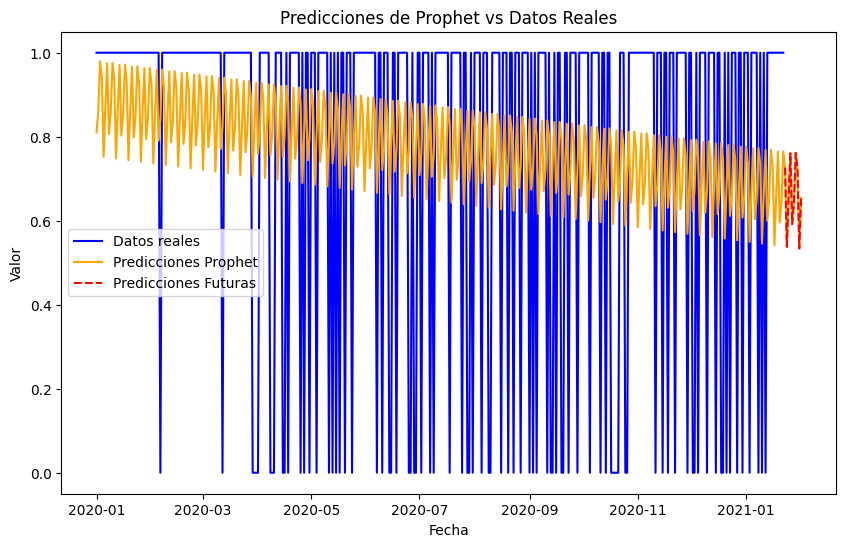

In [13]:
# Visualización de las predicciones de Prophet
plt.figure(figsize=(10, 6))
# Mostrar los datos originales
plt.plot(df_prophet['ds'], df_prophet['y'], label='Datos reales', color='blue')
# Mostrar las predicciones de Prophet
plt.plot(forecast['ds'], forecast['yhat'], label='Predicciones Prophet', color='orange')
# Resaltar las predicciones futuras
plt.plot(forecast['ds'].tail(periods_to_predict), y_pred_prophet, label='Predicciones Futuras', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones de Prophet vs Datos Reales')
plt.legend()
plt.show()

* Las predicciones no muestran fluctuaciones drásticas, sino valores relativamente estables a lo largo de los 10 períodos. Esto puede indicar que el modelo ha aprendido una tendencia general en los datos de entrada y que no se observa un cambio significativo en el comportamiento de la variable "Output" en los días futuros.
*  La serie de predicciones tiene una ligera variabilidad entre valores, lo cual es típico en modelos de series temporales cuando no hay grandes cambios en las tendencias o estacionalidades. Las variaciones de predicción no son excesivas, lo que sugiere que el modelo podría estar captando alguna tendencia moderada o un comportamiento de datos sin muchas oscilaciones drásticas.


### 5. Comparación de resultados:
  * Compara las predicciones de la red LSTM con las predicciones de Prophet. Utiliza métricas como el RMSE (Root Mean Squared Error) o el MAE (Mean Absolute Error) para medir la precisión de ambos modelos.
  * Visualiza las predicciones de ambos modelos superpuestas a la serie temporal original para ver cuál se ajusta mejor a los datos.

In [14]:
# Los valores reales de la serie temporal, por ejemplo, los últimos 10 días reales
y_true = df['Output'].tail(periods_to_predict).values
# Comparar las predicciones
# Para las predicciones de Prophet
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
# Para las predicciones de LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_true, y_pred_lstm[:periods_to_predict]))  # Asegúrate de que las dimensiones coincidan
mae_lstm = mean_absolute_error(y_true, y_pred_lstm[:periods_to_predict])  # Asegúrate de que las dimensiones coincidan
# Imprimir los resultados
print(f"RMSE LSTM: {rmse_lstm}")
print(f"MAE LSTM: {mae_lstm}")
print(f"RMSE Prophet: {rmse_prophet}")
print(f"MAE Prophet: {mae_prophet}")


RMSE LSTM: 0.1632349779894947
MAE LSTM: 0.13394471406936645
RMSE Prophet: 0.35036449217673443
MAE Prophet: 0.34103772333784554


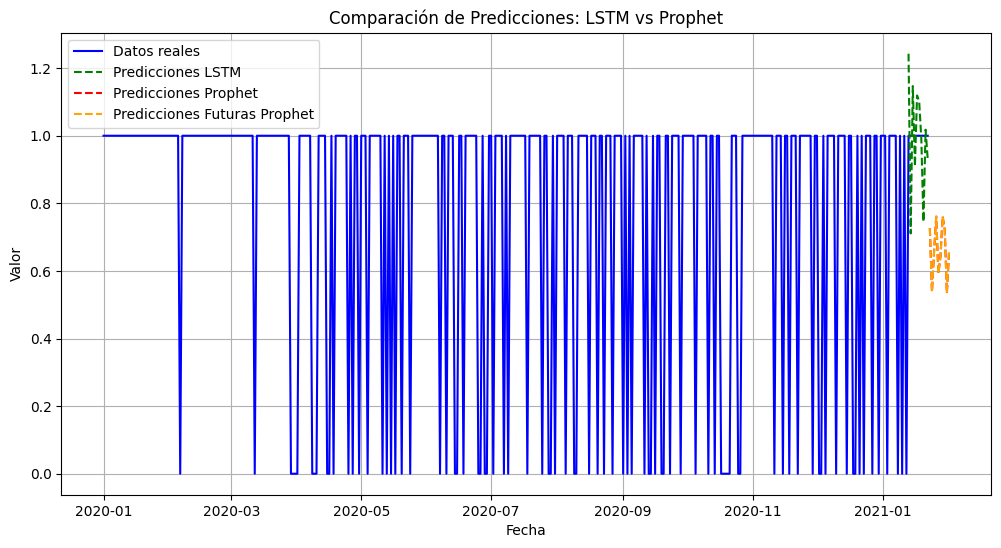

In [15]:
# Visualización de las predicciones de LSTM y Prophet junto con los datos reales
plt.figure(figsize=(12, 6))
# Mostrar los datos reales
plt.plot(df['date'], df['Output'], label='Datos reales', color='blue')
# Mostrar las predicciones del LSTM (Asegúrate de usar las últimas predicciones que corresponden a los días de test)
plt.plot(df['date'].tail(periods_to_predict), y_pred_lstm[:periods_to_predict], label='Predicciones LSTM', color='green', linestyle='--')
# Mostrar las predicciones de Prophet
plt.plot(forecast['ds'].tail(periods_to_predict), y_pred_prophet, label='Predicciones Prophet', color='red', linestyle='--')
# Resaltar las predicciones futuras de Prophet
plt.plot(forecast['ds'].tail(periods_to_predict), y_pred_prophet, label='Predicciones Futuras Prophet', color='orange', linestyle='--')
# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de Predicciones: LSTM vs Prophet')
plt.legend()
plt.grid(True)
plt.show()


### 6. Análisis y discusión:
  * Discute cuál de los modelos ofrece mejores resultados en este caso particular. ¿Por qué crees que Prophet o la red LSTM tuvieron un mejor rendimiento?
  * Reflexiona sobre las ventajas y desventajas de cada enfoque para la predicción de series temporales.

* Interpretación:
    * LSTM tiene un RMSE más bajo, lo que indica que, en promedio, las predicciones del LSTM están más cerca de los valores reales. El MAE también es más bajo para LSTM, lo que confirma que las predicciones de LSTM tienden a tener un menor error absoluto en comparación con las predicciones de Prophet.
    * RMSE y MAE de Prophet son significativamente más altos que los de LSTM. Esto sugiere que Prophet está haciendo un trabajo menos preciso al predecir los valores futuros en comparación con la red LSTM.

* Conclusión:
    * LSTM parece ser el modelo que tiene un mejor rendimiento para tus datos. Sus predicciones son más cercanas a los valores reales en términos de error cuadrático medio (RMSE) y error absoluto medio (MAE).
    * Prophet, aunque es un modelo sólido para series temporales, está teniendo un desempeño relativamente peor en este caso en particular, según las métricas de comparación.